In [69]:
!ruff format "drive/MyDrive/Colab Notebooks/Data_Dictionary_Aligned_analysis.py"




1 file reformatted


### Data Dictionary-Aligned Analysis: Resolving Schema Discrepancies

---


As part of our two-pronged approach to analyzing factors affecting delivery delays in the U.S. supply chain, this version of the dataset reflects the second approach, where we modified the data to match the provided documentation. In our first approach, we analyzed the dataset in its raw form. However, discrepancies were noted between the documented descriptions and the actual values—for instance, categorical variables like order fulfillment status, handling equipment availability, and cargo condition status appeared as continuous decimal values instead of binary indicators. In this cleaned version, we corrected these inconsistencies by converting affected fields to their appropriate categorical formats (e.g., 0 = not fulfilled, 1 = fulfilled) as per the official feature definitions. Additionally, we rounded all long decimal values to two decimal places to improve clarity and uniformity. This cleaned dataset is now available in the dataset/ folder of this repository and serves as the foundation for our refined analysis. You can access the cleaned dataset here.

### 1. Import Libraries

In [67]:
from IPython.display import display
from scipy.stats import pearsonr, spearmanr, kendalltau
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


### 2. Load Cleaned Dataset

In [12]:
# Load data
df=pd.read_csv('//content/secondApproach_dataset.csv')

### 3. Define ETA Status (Early, On-Time, Late)

In [13]:
# Define variables
features = [
    'traffic_congestion_level', 'warehouse_inventory_level', 'loading_unloading_time', 'handling_equipment_availability', 'weather_condition_severity', 'port_congestion_level',
    'shipping_costs', 'supplier_reliability_score', 'lead_time_days',
    'historical_demand', 'iot_temperature', 'cargo_condition_status',
    'route_risk_level', 'customs_clearance_time', 'driver_behavior_score',
    'fatigue_monitoring_score', 'disruption_likelihood_score'
]
targets = ['delay_probability', 'delivery_time_deviation', 'eta_variation_hours']

This classification uses ±0.5 hours as the tolerance window for 'On-Time' deliveries.

### 4. Plot ETA Status Distribution

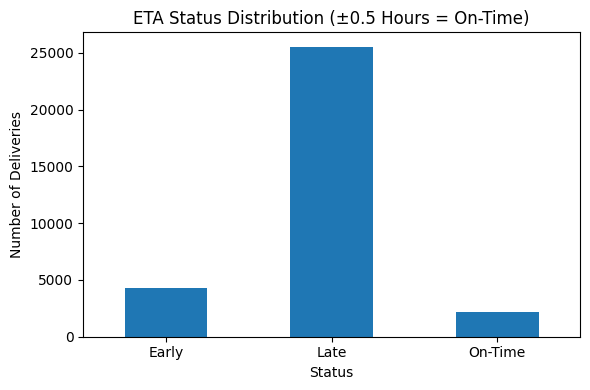

In [14]:
# Reclassify ETA_Status: only exact 0.00 as "On-Time"
df = df.copy()

# Reclassify ETA_Status using ±0.5 hour window as "On-Time"
def classify_eta_loose(val):
    if val < -0.5:
        return 'Early'
    elif val > 0.5:
        return 'Late'
    else:
        return 'On-Time'

# Apply classification
df['ETA_Status'] = df['eta_variation_hours'].apply(classify_eta_loose)
eta_counts_loose = df['ETA_Status'].value_counts().sort_index()

# Plot updated distribution
plt.figure(figsize=(6, 4))
eta_counts_loose.plot(kind='bar')
plt.title("ETA Status Distribution (±0.5 Hours = On-Time)")
plt.xlabel("Status")
plt.ylabel("Number of Deliveries")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


The bar chart shows how many deliveries were classified as Early, On-Time, or Late based on ETA variation.

/tmp/ipython-input-15-3343864292.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_resampled = df['eta_variation_hours'].resample('M').mean()


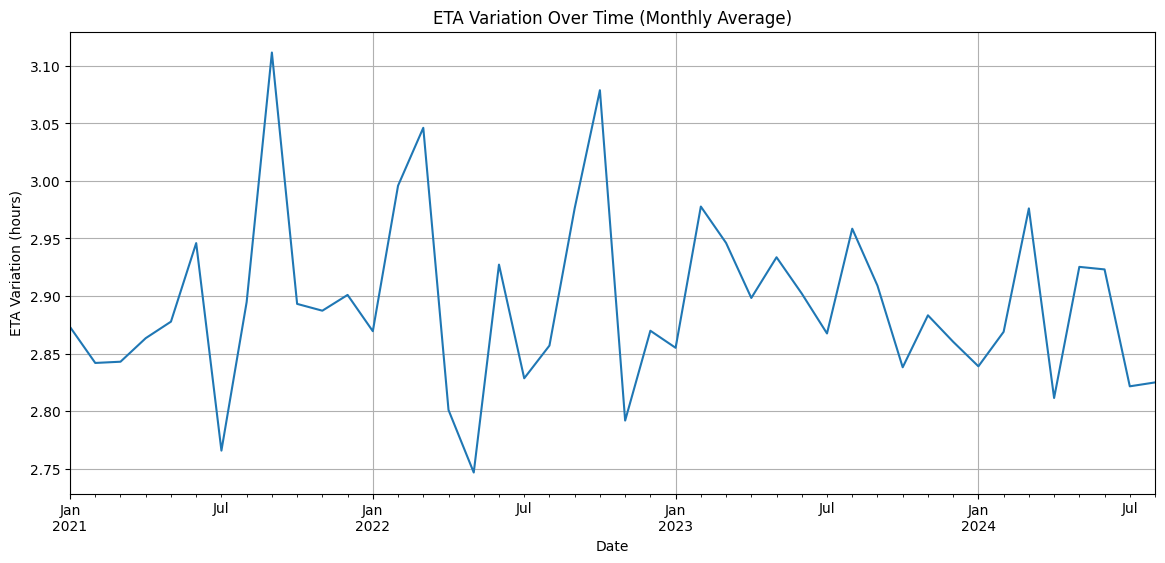

In [15]:
# Load data

# Convert 'timestamp' to datetime and set as index
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')

df_resampled = df['eta_variation_hours'].resample('M').mean()

plt.figure(figsize=(14, 6))
df_resampled.plot()
plt.title('ETA Variation Over Time (Monthly Average)')
plt.ylabel('ETA Variation (hours)')
plt.xlabel('Date')
plt.grid(True)
plt.show()

### 5. Pearson Correlation for Interaction Features vs Target Variables

In [16]:

# Define features and targets again
features = [
    'route_risk_level', 'port_congestion_level', 'warehouse_inventory_level',
    'disruption_likelihood_score', 'historical_demand', 'fatigue_monitoring_score',
    'handling_equipment_availability', 'driver_behavior_score', 'traffic_congestion_level',
    'shipping_costs', 'iot_temperature', 'customs_clearance_time',
    'cargo_condition_status', 'weather_condition_severity', 'loading_unloading_time',
    'supplier_reliability_score', 'lead_time_days'
]

targets = ['eta_variation_hours', 'delay_probability', 'delivery_time_deviation']

# Calculate Pearson correlation and store results in DataFrame
result_table = []

for target in targets:
    for feature in features:
        try:
            corr, _ = pearsonr(df[feature], df[target])
            result_table.append({
                'Target': target,
                'Feature': feature,
                'Pearson Correlation': corr
            })
        except Exception as e:
            result_table.append({
                'Target': target,
                'Feature': feature,
                'Pearson Correlation': None,
                'Error': str(e)
            })

# Convert to DataFrame
pearson_df = pd.DataFrame(result_table)

# Sort by absolute correlation value for each target
pearson_df['abs_corr'] = pearson_df['Pearson Correlation'].fillna(0).abs()
pearson_df = pearson_df.sort_values(by=['Target', 'abs_corr'], ascending=[True, False]).drop(columns='abs_corr')

# Show to user
display(pearson_df)

,Target,Feature,Pearson Correlation
18,delay_probability,port_congestion_level,0.008895
20,delay_probability,disruption_likelihood_score,-0.008019
28,delay_probability,customs_clearance_time,0.004840
23,delay_probability,handling_equipment_availability,0.004708
19,delay_probability,warehouse_inventory_level,0.004563
24,delay_probability,driver_behavior_score,-0.003881
25,delay_probability,traffic_congestion_level,-0.003824
17,delay_probability,route_risk_level,-0.003366
21,delay_probability,historical_demand,-0.002913
32,delay_probability,supplier_reliability_score,0.001856


This table summarizes the Pearson correlation between each feature and all target variables.

### 8. Calculate Pearson Correlations with Selected Features

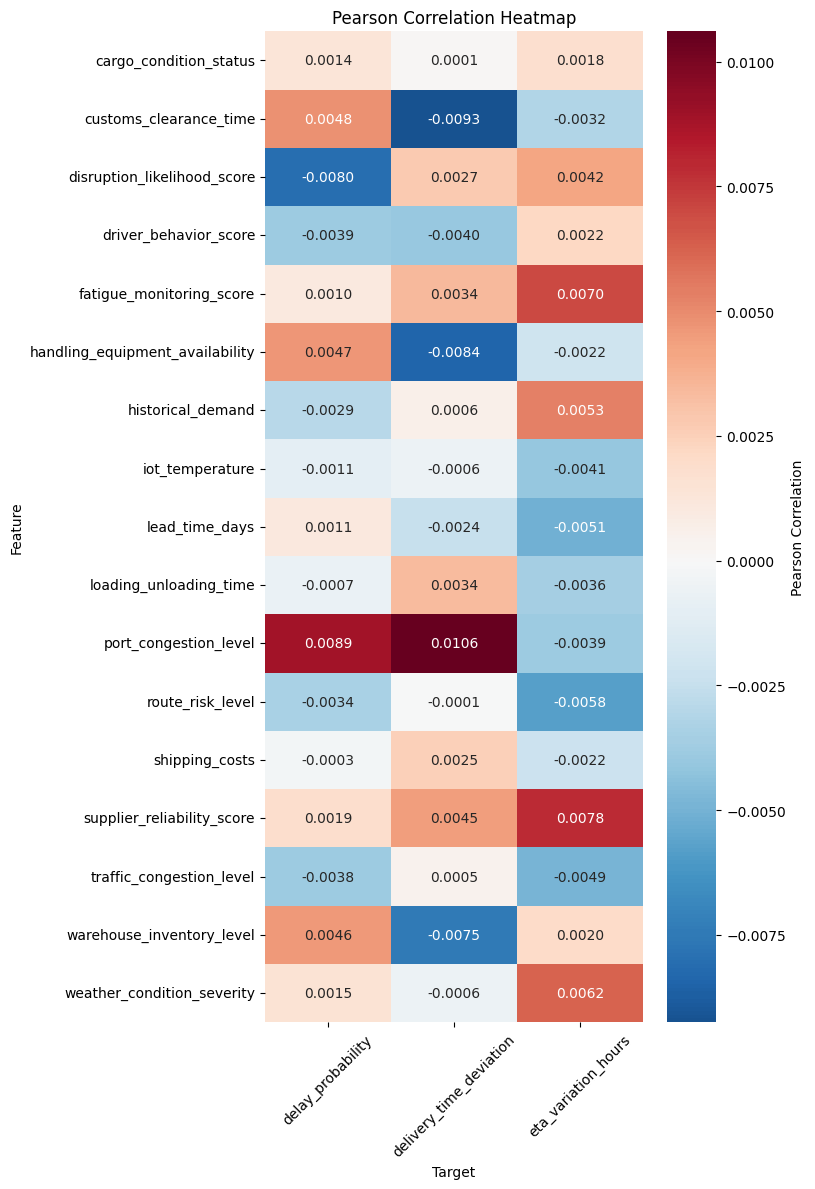

In [17]:
# Create Pearson heatmap
data = []
for index, row in pearson_df.iterrows():
    data.append({'Feature': row['Feature'], 'Target': row['Target'], 'Correlation': row['Pearson Correlation']})


df_pearson = pd.DataFrame(data)
pivot_pearson = df_pearson.pivot(index='Feature', columns='Target', values='Correlation')

plt.figure(figsize=(8, 12))
sns.heatmap(pivot_pearson, annot=True, cmap='RdBu_r', center=0, fmt='.4f',
            cbar_kws={'label': 'Pearson Correlation'})
plt.title('Pearson Correlation Heatmap')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 9. Display Spearman Correlation Results in Table Format

In [19]:

# Define features and targets (ensure they are defined)
features = [
    'route_risk_level', 'port_congestion_level', 'warehouse_inventory_level',
    'disruption_likelihood_score', 'historical_demand', 'fatigue_monitoring_score',
    'handling_equipment_availability', 'driver_behavior_score', 'traffic_congestion_level',
    'shipping_costs', 'iot_temperature', 'customs_clearance_time',
    'cargo_condition_status', 'weather_condition_severity', 'loading_unloading_time',
    'supplier_reliability_score', 'lead_time_days'
]

targets = ['eta_variation_hours', 'delay_probability', 'delivery_time_deviation']


# Calculate Spearman correlation and store results in DataFrame
spearman_table = []

for target in targets:
    for feature in features:
        try:
            corr, _ = spearmanr(df[feature], df[target])
            spearman_table.append({
                'Target': target,
                'Feature': feature,
                'Spearman Correlation': corr
            })
        except Exception as e:
            spearman_table.append({
                'Target': target,
                'Feature': feature,
                'Spearman Correlation': None,
                'Error': str(e)
            })

# Convert to DataFrame
spearman_df = pd.DataFrame(spearman_table)

# Sort by absolute correlation value for each target
spearman_df['abs_corr'] = spearman_df['Spearman Correlation'].fillna(0).abs()
spearman_df = spearman_df.sort_values(by=['Target', 'abs_corr'], ascending=[True, False]).drop(columns='abs_corr')

# Show to user
display(spearman_df)

,Target,Feature,Spearman Correlation
17,delay_probability,route_risk_level,-0.006458
18,delay_probability,port_congestion_level,0.006251
19,delay_probability,warehouse_inventory_level,0.006092
20,delay_probability,disruption_likelihood_score,-0.005554
21,delay_probability,historical_demand,-0.005525
22,delay_probability,fatigue_monitoring_score,0.004693
24,delay_probability,driver_behavior_score,-0.003825
25,delay_probability,traffic_congestion_level,-0.003484
23,delay_probability,handling_equipment_availability,0.003452
26,delay_probability,shipping_costs,-0.002468


This table shows the Spearman rank-order correlation for feature-target relationships.

### 10. Calculate Spearman Correlations with Selected Features

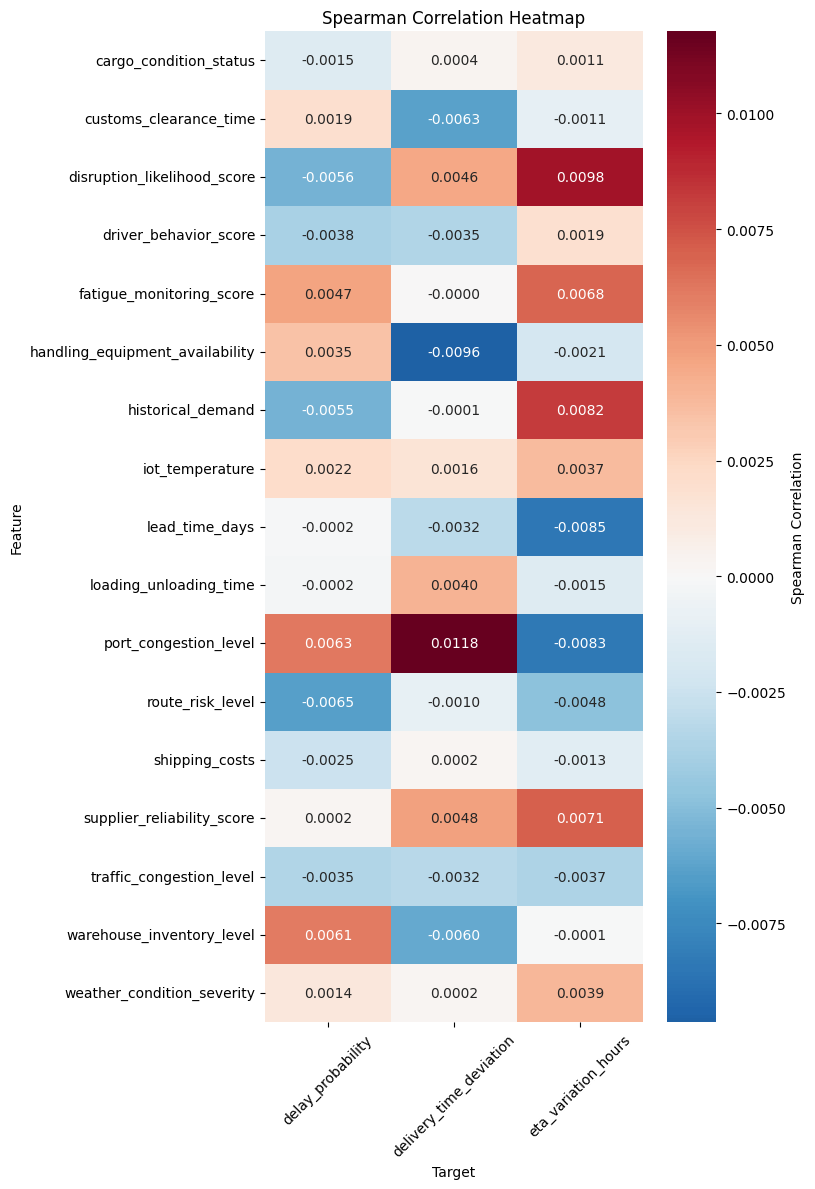

In [20]:
# Create spearman heatmap
data = []
for index, row in spearman_df.iterrows():
    data.append({
        'Feature': row['Feature'],
        'Target': row['Target'],
        'Correlation': row['Spearman Correlation']
    })

df_spearman = pd.DataFrame(data)
pivot_spearman = df_spearman.pivot(index='Feature', columns='Target', values='Correlation')

plt.figure(figsize=(8, 12))
sns.heatmap(pivot_spearman, annot=True, cmap='RdBu_r', center=0, fmt='.4f',
            cbar_kws={'label': 'Spearman Correlation'})
plt.title('Spearman Correlation Heatmap')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This table presents Kendall Tau correlations, a non-parametric measure of ordinal association.

### 12. Calculate Kendall Tau Correlation in Table format

In [43]:

# Calculate Kendall Tau correlation and store results in DataFrame
kendall_table = []

for target in targets:
    for feature in features:
        try:
            corr, _ = kendalltau(df[feature], df[target])
            kendall_table.append({
                'Target': target,
                'Feature': feature,
                'Kendall Correlation': corr
            })
        except Exception as e:
            kendall_table.append({
                'Target': target,
                'Feature': feature,
                'Kendall Correlation': None,
                'Error': str(e)
            })

# Convert to DataFrame
kendall_df = pd.DataFrame(kendall_table)

# Sort by absolute correlation value for each target
kendall_df['abs_corr'] = kendall_df['Kendall Correlation'].abs()
kendall_df = kendall_df.sort_values(by=['Target', 'abs_corr'], ascending=[True, False]).drop(columns='abs_corr')

# Show to user
display(kendall_df)

,Target,Feature,Kendall Correlation
17,delay_probability,route_risk_level,-0.004395
18,delay_probability,port_congestion_level,0.004265
19,delay_probability,warehouse_inventory_level,0.004167
20,delay_probability,disruption_likelihood_score,-0.003935
21,delay_probability,historical_demand,-0.003753
22,delay_probability,fatigue_monitoring_score,0.003223
23,delay_probability,handling_equipment_availability,0.002872
24,delay_probability,driver_behavior_score,-0.002602
25,delay_probability,traffic_congestion_level,-0.002356
26,delay_probability,shipping_costs,-0.001663


The heatmap shows how pairwise interactions between features relate to ETA variation, delay probability, and delivery deviation.

### 14. Kendall's Tau Correlation

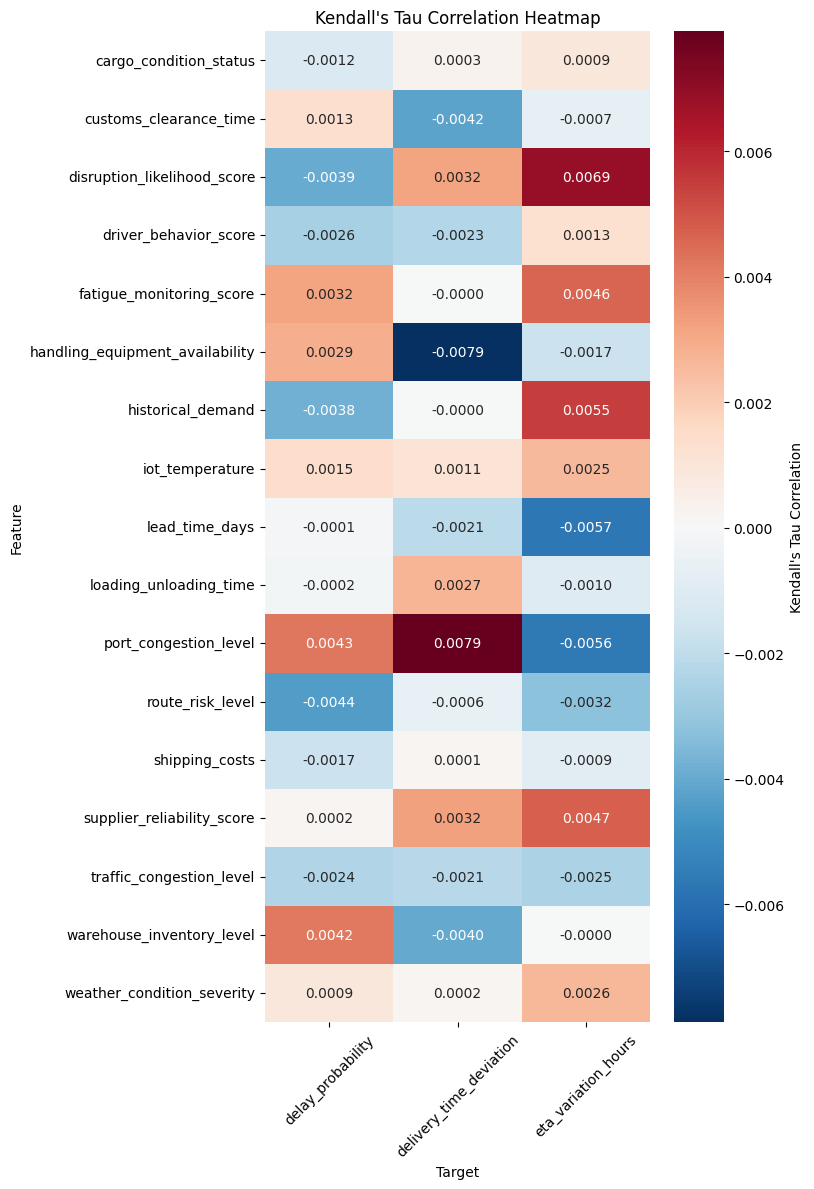

In [22]:
data = []
for index, row in kendall_df.iterrows():
    data.append({'Feature': row['Feature'], 'Target': row['Target'], 'Correlation': row['Kendall Correlation']})

df_kendall = pd.DataFrame(data)
pivot_kendall = df_kendall.pivot(index='Feature', columns='Target', values='Correlation')

plt.figure(figsize=(8, 12))
sns.heatmap(pivot_kendall, annot=True, cmap='RdBu_r', center=0, fmt='.4f',
            cbar_kws={'label': "Kendall's Tau Correlation"})
plt.title("Kendall's Tau Correlation Heatmap")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Only the most impactful interactions are kept based on their maximum correlation with any target.

### 15. Scatter Plots of Top Interaction Features vs Target Variables

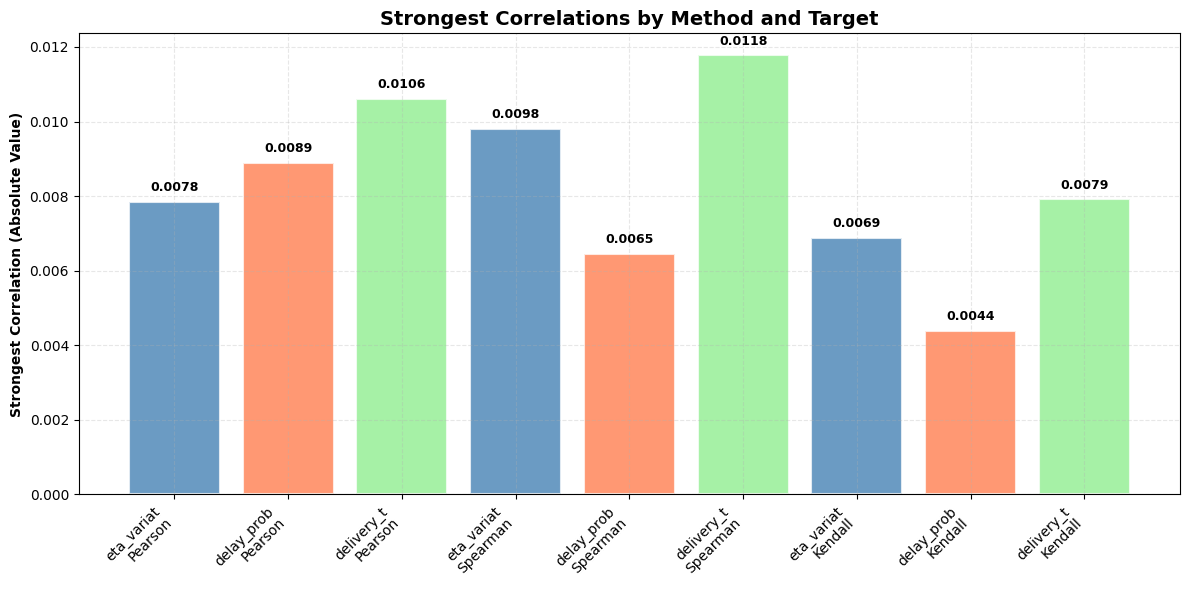


Top correlations:
ETA_VARIATION_HOURS: P:0.0078 | S:0.0098 | K:0.0069
DELAY_PROBABILITY: P:0.0089 | S:0.0065 | K:0.0044
DELIVERY_TIME_DEVIATION: P:0.0106 | S:0.0118 | K:0.0079


In [23]:
# bar chart comparison of strongest correlations
# Extract data and create enhanced visualization
data = []

# Get strongest Pearson correlations
for target in targets:
    strongest_pearson = pearson_df[pearson_df['Target'] == target].iloc[0]
    data.append((abs(strongest_pearson['Pearson Correlation']), f"{target[:10]}\nPearson"))

# Get strongest Spearman correlations
for target in targets:
    strongest_spearman = spearman_df[spearman_df['Target'] == target].iloc[0]
    data.append((abs(strongest_spearman['Spearman Correlation']), f"{target[:10]}\nSpearman"))

# Get strongest Kendall correlations
for target in targets:
    strongest_kendall = kendall_df[kendall_df['Target'] == target].iloc[0]
    data.append((abs(strongest_kendall['Kendall Correlation']), f"{target[:10]}\nKendall"))


corrs, labels = zip(*data)
colors = ['steelblue', 'coral', 'lightgreen'] * len(targets)

plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(corrs)), corrs, color=colors, alpha=0.8,
               edgecolor='white', linewidth=1.5)

plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
plt.ylabel('Strongest Correlation (Absolute Value)', fontweight='bold')
plt.title('Strongest Correlations by Method and Target', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')

# Add value labels
for bar, corr in zip(bars, corrs):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.0002,
             f'{corr:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# summary
print("\nTop correlations:")
for target in targets:
    print(f"{target.upper()}: P:{abs(pearson_df[pearson_df['Target'] == target].iloc[0]['Pearson Correlation']):.4f} | "
          f"S:{abs(spearman_df[spearman_df['Target'] == target].iloc[0]['Spearman Correlation']):.4f} | "
          f"K:{abs(kendall_df[kendall_df['Target'] == target].iloc[0]['Kendall Correlation']):.4f}")

These scatter plots illustrate the relationships between the top interaction terms and each target variable.

### 16. Correlation of Interaction features with Target Varibales

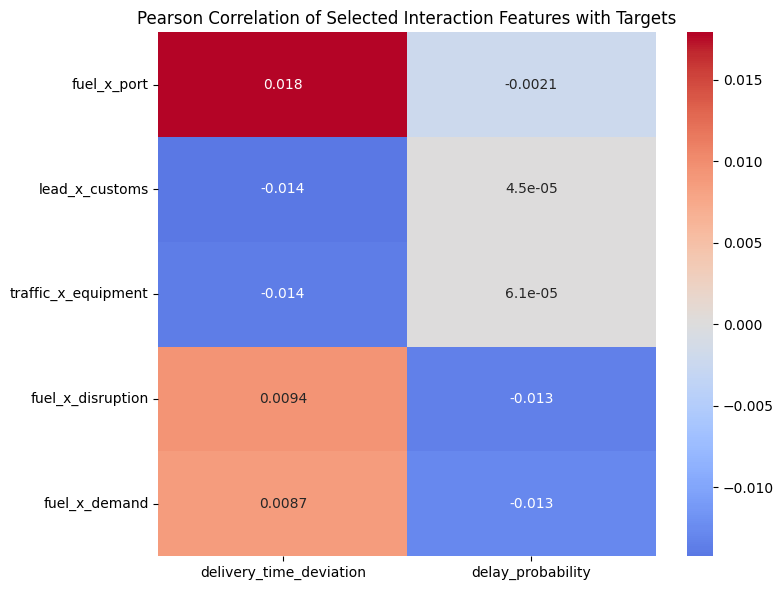

In [25]:
# Create interaction features

df['fuel_x_port'] = df['fuel_consumption_rate'] * df['port_congestion_level']
df['lead_x_customs'] = df['lead_time_days'] * df['customs_clearance_time']
df['traffic_x_equipment'] = df['traffic_congestion_level'] * df['handling_equipment_availability']
df['fuel_x_disruption'] = df['fuel_consumption_rate'] * df['disruption_likelihood_score']
df['fuel_x_demand'] = df['fuel_consumption_rate'] * df['historical_demand']

# Define features and targets
interaction_features = [
    'fuel_x_port',
    'lead_x_customs',
    'traffic_x_equipment',
    'fuel_x_disruption',
    'fuel_x_demand'
]
targets = ['delivery_time_deviation', 'delay_probability']

# Combine into one DataFrame for correlation
corr_df = df[interaction_features + targets]

# Compute Pearson correlation matrix
correlation_matrix = corr_df.corr(method='pearson')

# Subset: correlation of interaction features vs. targets
correlation_subset = correlation_matrix.loc[interaction_features, targets]

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_subset, annot=True, cmap='coolwarm', center=0)
plt.title('Pearson Correlation of Selected Interaction Features with Targets')
plt.tight_layout()
plt.show()

This plot shows the distribution of delivery ETA status with 'On-Time' defined as within ±0.5 hours.